# Basic Imports for a Deep Learning(DL) Project
-----

Most deep learning projects will use the following set of libraries:
.
* numpy  - Core numerical processing libarry in python, moslty a python wrapper for optimized C and Fortran.
* pandas - Default Data processing libriary, stores a dataset in "DataFrame" object that's an in-memory columnar store(by default), builds upon numpy.
* sklearn - Default Machine Learning library for python, lot's of useful data processing utils, works well with pandas.
* keras - Deep Learning Library that wraps and abstracts tensorflow (or theano), provides a simple intutive high level API for developing deep learning models and is the most popular solution by far for writing Deep Learning Code. The specific layers you import from keras will differ based on the task. Below are some common Layers used in NLP(e.g. Embedding, LSTM, GRU)
* tensorflow - Google's DL Library, Keras code runs tensorflow "graphs" to handle the computations, which are actually run in C++

In [1]:
import os
import re

import numpy as np
import tensorflow as tf

np.random.seed(1)
tf.random.set_seed(2)

import pandas as pd
import keras
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, classification_report, log_loss

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Flatten
from keras.layers import Dropout, Conv1D, GlobalMaxPool1D, GRU, GlobalAvgPool1D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

# print(os.listdir('./trai'))

In [2]:
#training constants
MAX_SEQ_LEN = 25 #this is based on a quick analysis of the len of sequences train['text'].apply(lambda x : len(x.split(' '))).quantile(0.95)
DEFAULT_BATCH_SIZE = 128

#  Import Data and Prep For Model 
----

Steps:
* Data is loaded into pandas
* Data is split into train and test datasets (training is used to train the model and test is used to evaluate the predictions)
 * In most implementations you also have a validation dataset that you use to tune your model
* Text Data is cleaned for common mappings
* Data is tokenized into integer keys for lookups to the Embedding Matrix(discussed below)

### Import data into pandas and split into train and test set (usually would also have a 3rd split for validation)

In [3]:
data = pd.read_csv('./training.1600000.processed.noemoticon.csv', encoding='latin-1')
# data = data[data['sentiment'] != 'Neutral']


In [4]:
DATASET_COLUMNS = ["sentiment", "ids", "date", "flag", "user", "text"] # positive is 1
data.columns = DATASET_COLUMNS

In [5]:
sample_size = 1600

positive_data = data[data.sentiment==4].iloc[:sample_size]
print(positive_data.shape)
negative_data = data[data.sentiment==0].iloc[:sample_size]
print(negative_data.shape)
data = pd.concat([positive_data,negative_data],axis = 0)
print(data.shape)
data.head()

data.describe().T

(1600, 6)
(1600, 6)
(3200, 6)


,count,mean,std,min,25%,50%,75%,max
sentiment,3200.0,2.000000e+00,2.000313,0.000000e+00,0.000000e+00,2.000000e+00,4.000000e+00,4.000000e+00
ids,3200.0,1.467986e+09,99867.777386,1.467811e+09,1.467900e+09,1.467987e+09,1.468068e+09,1.468193e+09


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3200 entries, 799999 to 1599
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  3200 non-null   int64 
 1   ids        3200 non-null   int64 
 2   date       3200 non-null   object
 3   flag       3200 non-null   object
 4   user       3200 non-null   object
 5   text       3200 non-null   object
dtypes: int64(2), object(4)
memory usage: 175.0+ KB


In [7]:
train, test = train_test_split(data, random_state = 42, test_size=0.1)
print(train.shape)
print(test.shape)

(2880, 6)
(320, 6)


In [8]:
# Mapping of common contractions, could probbaly be done better
CONTRACTION_MAPPING = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have",
                       "It's": 'It is', "Can't": 'Can not',
                      }

In [9]:
def clean_text(text, mapping):
    replace_white_space = ["\n"]
    for s in replace_white_space:
        text = text.replace(s, " ")
    replace_punctuation = ["’", "‘", "´", "`", "\'", r"\'"]
    for s in replace_punctuation:
        text = text.replace(s, "'")
    
    # Random note: removing the URL's slightly degraded performance, it's possible the model learned that certain URLs were positive/negative
    # And was able to extrapolate that to retweets. Could also explain why re-training the Embeddings improves performance.
    # remove twitter url's
#     text = re.sub(r"http[s]?://t.co/[A-Za-z0-9]*","TWITTERURL",text)
    mapped_string = []
    for t in text.split(" "):
        if t in mapping:
            mapped_string.append(mapping[t])
        elif t.lower() in mapping:
            mapped_string.append(mapping[t.lower()])
        else:
            mapped_string.append(t)
    return ' '.join(mapped_string)

### Tokenize Text, which involves converting each sequence into an integer encoded represenation and normalizing the length of the sequences. Please note very little pre-processing is done to the text. More specifically there's no stemming or POS tagging, common in NLP tasks. Additionally, text is left in original case (i.e not cast to lowercase).

### This is one of the main selling points of Deep Learning methods, that it's able to produce high quality results with minimal pre-processing or "expert" feature engineering. Though in practice adding "novel" features can improve the quality of the model (speed to convergence and accuracy of results). 

In [10]:
# Get tweets from Data frame and convert to list of "texts" scrubbing based on clean_text function
# CONTRACTION_MAPPING is a map of common contractions(e.g don't => do not)
train_text_vec = [clean_text(text, CONTRACTION_MAPPING) for text in train['text'].values]
test_text_vec = [clean_text(text, CONTRACTION_MAPPING) for text in test['text'].values]


# tokenize the sentences
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(train_text_vec)
train_text_vec = tokenizer.texts_to_sequences(train_text_vec)
test_text_vec = tokenizer.texts_to_sequences(test_text_vec)

# pad the sequences
train_text_vec = pad_sequences(train_text_vec, maxlen=MAX_SEQ_LEN)
test_text_vec = pad_sequences(test_text_vec, maxlen=MAX_SEQ_LEN)

print('Number of Tokens:', len(tokenizer.word_index))
print("Max Token Index:", train_text_vec.max(), "\n")

print('Sample Tweet Before Processing:', train["text"].values[0])
print('Sample Tweet After Processing:', tokenizer.sequences_to_texts([train_text_vec[0]]), '\n')

print('What the model will interpret:', train_text_vec[0].tolist())


Number of Tokens: 8827
Max Token Index: 8827 

Sample Tweet Before Processing: @dragoneer Yea   I am working tp hack my server to do the 12player thing for folks
Sample Tweet After Processing: ['dragoneer Yea I am working tp hack my server to do the 12player thing for folks'] 

What the model will interpret: [0, 0, 0, 0, 0, 0, 0, 0, 0, 2660, 1610, 1, 14, 237, 2661, 2662, 8, 1611, 2, 24, 3, 2663, 145, 13, 1160]


### Prepping output data. In this case the sentiment is classified as Negative, Neutral or Positive. To make it suitable for a deep learning model each sentiment will be converted to a vector of length 3, where each position corresponds to a sentiment class: Negative = 0, Neutral = 1 and Positive = 2

In [11]:
# One Hot Encode Y values:
encoder = LabelEncoder()

y_train = encoder.fit_transform(train['sentiment'].values)
y_train = to_categorical(y_train) 

y_test = encoder.fit_transform(test['sentiment'].values)
y_test = to_categorical(y_test) 

### This will be used to weight the training, useful when you have large class imbalances, can speed training and improve results. Alternatively you can balance the classes in the input, so there are equal numbers

In [12]:
# get an idea of the distribution of the text values
from collections import Counter
ctr = Counter(train['sentiment'].values)
print('Distribution of Classes:', ctr)

# get class weights for the training data, this will be used data
y_train_int = np.argmax(y_train,axis=1)
cws = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_int), y=y_train_int)
print(cws)

Distribution of Classes: Counter({0: 1463, 4: 1417})
[0.98427888 1.01623147]


# Baselines
---

It's highly recommended to define some baselines for the model for the following reasons:
* It allows you to determine if your model beats basic ML approaches. Most Deep Learning models should improve over simple ML Algorithms so if you're not seeing that you might want to either tune your model or debug it for errors
* It gives you an idea if the trade-offs are meaningful. Deep Learning usually requires more expensive comupte costs (e.g. GPUs) and depending on your goal, the increase in performance from a DL approach might not offset the added cost / time complexity. Simple Algorithms like Logistic Regression can even be implemented as in line SQL, while pretty much any DL task will require setting up additional infrastructure to deploy your model. 

Some common Baseline's:
* Predict the dominat class: if you just guess the most frequent class what accuracy do you get? This is the simplest (and should be least accurate) model possible. In the case of twitter always assume the tweet is negative...
* Other common classification models. In this case I tried NaiveBayes (an oldy but a goody) and RandomForestClassifier (the go to model for ML Tasks before Deep Learning became dominant). 
* Have an expert (or several) perform the same classification task themselves and use their Accuracy/Error Rate as a Human Level Benchmark.



The goal is not to necessarily tune these to extract high performance, but just get a sense of how the perform (and if you're DL model is improving).



In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

np.set_printoptions(precision=4)
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # Compute confusion matrix
    classes = classes[unique_labels(y_true, y_pred)]
    _cm = confusion_matrix(y_true, y_pred)

    print(classification_report(y_true, y_pred, target_names=classes))
        
    def _build_matrix(fig, ax, cm, normalize = False):
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        im = ax.imshow(cm, cmap=cmap)
#         fig.colorbar(im, ax=ax)
        
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=classes, 
               yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        
    fig, [ax1, ax2] = plt.subplots(nrows = 1, ncols = 2, figsize=(8, 4))
    _build_matrix(fig, ax1, cm = _cm, normalize=False)
    _build_matrix(fig, ax2, cm = _cm, normalize=True)
    fig.tight_layout()


In [14]:
# 
print('Dominant Class: ', ctr.most_common(n = 1)[0][0])
print('Baseline Accuracy Dominant Class', (ctr.most_common(n = 1)[0][0] == test['sentiment'].values).mean())

preds = np.zeros_like(y_test)
preds[:, 0] = 1
preds[0] = 1 #done to suppress warning from numpy for f1 score
print('F1 Score:', f1_score(y_test, preds, average='weighted'))


Dominant Class:  0
Baseline Accuracy Dominant Class 0.428125
F1 Score: 0.256687636761488


In [15]:
# Naive Bayse Baseline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
text_clf.fit(tokenizer.sequences_to_texts_generator(train_text_vec), y_train.argmax(axis=1))
predictions = text_clf.predict(tokenizer.sequences_to_texts_generator(test_text_vec)) 
print('Baseline Accuracy Using Naive Bayes: ', (predictions == y_test.argmax(axis = 1)).mean())
print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions, average='weighted'))

# _ = plot_confusion_matrix(y_test.argmax(axis = 1), predictions, classes=encoder.classes_, title='Confusion matrix, without normalization')

Baseline Accuracy Using Naive Bayes:  0.64375
F1 Score: 0.6443345639943742


TypeError: object of type 'numpy.int64' has no len()

### Naive Bayes is a good baseline, but is not robust to imblanced  datasets, common with classification of "real-world" data. See [here](https://stats.stackexchange.com/questions/99667/naive-bayes-with-unbalanced-classes) for some methods for overcoming class imbalance. In this case rebalancing the data would require throwing away a lot of negative examples or significantly oversampling the positive an neutral cases. 

### Another good baseline is a RandomForestClassifier, which for years prior to the Deep Learning explosion reigned as the model of choice for classifcation tasks, below is a simple implementation, with some recommended parameters (one specifically to handle classs imbalance, the other increases the "complexity" of the model to the new standard default).

In [16]:
# Random Forest Baseline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(class_weight='balanced', n_estimators=100)), #100 estimators will be the new default in version 0.22
])
text_clf.fit(tokenizer.sequences_to_texts_generator(train_text_vec), y_train.argmax(axis=1))
predictions = text_clf.predict(tokenizer.sequences_to_texts_generator(test_text_vec)) 
print('Baseline Accuracy Using RFC: ', (predictions == y_test.argmax(axis = 1)).mean())
print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions, average='weighted'))

# _ = plot_confusion_matrix(y_test.argmax(axis = 1), predictions, classes=encoder.classes_)

Baseline Accuracy Using RFC:  0.659375
F1 Score: 0.6610936869903906


TypeError: object of type 'numpy.int64' has no len()

## Reviewing our Baselines

The metric we'll be interested are Accuracy, which is self-explanatory and [F1 Score](https://en.wikipedia.org/wiki/F1_score), which blends the precision and recall scores for each class. F1 Score is generally a better measure of the performance of a model, especially when classes are imbalanced.

Between our Baselines the Random Forest Classifier performs the best by a large margin (mostly because it's robust to class imbalance). 

***Our goal is to see if we can produce a model that has a F1 Score > ~0.65***

Specifically, you'll see the model become better at distinguishing the Neutral and Positive Tweets from the Negative one's


# Building(and Evolving) Neural Networks
----

###  So now that we've done all of the prep work it's time to do some actual Neural Network-ing
### Neural Nets are like legos! And part of the fun (and frustration) comes from experimenting with different configurations to see which architecture produces the best results. One nice aspect of Neural Nets is that unlike other ML Approaches you can "stack" modules onto a Neural Net to improve there performance as we'll see below the first Neural Net will surpass the performance of the Random Forest, and by the end we should have one that has an F1 Score > ***0.7***, ~ 8% improvement (before any tuning). 

### To get there we'll train around 7 different architectures each one building on the prior.

----


### All of the neural nets we'll be using are based on Recurrent Neural Network(RNN) Architecture. 
#### An RNN is a specific type of Deep Learning Architecture that's specially adapted to handle time dependent information such as human language (e.g. Text, Audio), signal outputs from an IoT Device, or any other Time Series based data(stock prices, though not recommeneded). An LSTM is a specific type of RNN and is used in a lot of commercial applications(Siri), also consider GRU's, which can occasionally outperform LSTMs on certain tasks and ther are more advanced models as well (like Attention, BERT, 1D Convolutions, Capsules, etc).

### Below is an illustration of an RNN Style Architecture
#### For each timestep you have some data that's input `x` and an activation `A`, which outputs a new state `h`, the important thing about RNN and LSTM's is that the state information from prior states is used as input to the next state, which means that the model builds a state vector overtime that incporporates prior information. This improves upon the bag-of-words models that are used in classical ML, which are word/token based and don't normally incorporate the context that words are used in (e.g. "the leaves are orange in fall" vs "he often leaves from work at noon"). This was addressed through n-gram based models, but the exponential increase in input data makes such models intractable in most applications.

![LSTM Drawing](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)



## Below is a quick method used to train the models

In [22]:

def threshold_search(y_true, y_proba, average = None):
    best_threshold = 0
    best_score = 0
    for threshold in [i * 0.01 for i in range(100)]:
        score = f1_score(y_true=y_true, y_pred=y_proba > threshold, average=average)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result


def train(model, 
          X_train, y_train, X_test, y_test, 
          checkpoint_path='model.hdf5', 
          epcohs = 25, 
          batch_size = DEFAULT_BATCH_SIZE, 
          class_weights = None, 
          fit_verbose=2,
          print_summary = True
         ):
    m = model()
    if print_summary:
        print(m.summary())
    m.fit(
        X_train, 
        y_train, 
        #this is bad practice using test data for validation, in a real case would use a seperate validation set
        validation_data=(X_test, y_test),  
        epochs=epcohs, 
        batch_size=batch_size,
        class_weight=class_weights,
         #saves the most accurate model, usually you would save the one with the lowest loss
        callbacks= [
            ModelCheckpoint(checkpoint_path, monitor='val_acc', verbose=1, save_best_only=True),
            EarlyStopping(patience = 2)
        ],
        verbose=fit_verbose
    ) 
    print("\n\n****************************\n\n")
    print('Loading Best Model...')
    m.load_weights(checkpoint_path)
    predictions = m.predict(X_test, verbose=1)
    print('Validation Loss:', log_loss(y_test, predictions))
    print('Test Accuracy', (predictions.argmax(axis = 1) == y_test.argmax(axis = 1)).mean())
    print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions.argmax(axis = 1), average='weighted'))
    plot_confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1), classes=encoder.classes_)
    plt.show()    
    return m #returns best performing model

# Important Note, when Evaluating Models - Look at Loss not Accuracy....

### For each model we'll produces several stats, including the Accuracy and F1, and Loss on the Validation Set. In most cases you want to minimize the Loss. But you might also find it helpful to maximize the Accuracy or F1-Score (or other performance metric). For more complicated metrics it might not be possible to directy optimize your model for that metric and you might want to consider alternative techniques (e.g. In this case I use Model CheckPointing and EarlyStopping based on Accuracy to ensure that I pick the "best" model. For Example, F1-Score is not differentiable, so there's no straighforward way (currently) to train your model to  optimize for it. Though Accuracy can be a good proxy to start.

### In some cases below I'll make "improvements" that substantially decrease the Loss, but may have a nominal effect on the Accuracy(or even lower accuracy), building on those lower Loss solutions though will generally produce a better model.


## First Neural network is a simple implementation of an LSTM. The layers are as follows:
* Embedding - Matrix of Word Vectors, where each vector store the "meaning" of the word. These can be trained on the fly or you can leverage existing pre-trained vector.
* LSTM - Recurrent Neural Network that allows for the "building" of state over time
* Dense(64) - Feed Forward Neural Net used to interpret the LSTM Output
* Dense(3) - This it the output of the model, 3 nodes corresponding to each class. The softmax output will ensure that the sum of values = 1.0 for each output.

### Even this basic architecture of just 3 Layers already beats the Random Forest Classifer in terms of Accuracy and F1 Score (resutls may depend on run)


In [25]:
def model_1():
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(LSTM(128))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

m1 = train(model_1, 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           checkpoint_path='model_1.h5',
           class_weights=cws
          )


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 25, 128)           2751744   
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2,891,779
Trainable params: 2,891,779
Non-trainable params: 0
_________________________________________________________________
None


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Now that we have a good baseline Neural Network Architecture we'll begin building on it. By adding more layers and increasing the complexity.
#### The first improvement is to use a Bi-Derectional LSTM. As the name suggest this Layer "reads" text both forwards and backwards and allows the model to get information from past and future states simultaneously. It also usually provides a nice boost in performance over the single pass LSTM. 

#### Dropout is also added to reduce overfitting, as the number of paramters in the model increases. A Dropout Layer, drops data from the input, but only during training, which encourages the model to be more "robust" and not become overly dependent on specific signals from the training data to make predictions. Since we have a relatively small data-set compared to our model size, drop-out is critical to ensure the model doesnt just quickly overfit the training set. 

In [24]:
def model_1b():
    """
    Using a Bidiretional LSTM. 
    """
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25)))
    model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

_ = train(model_1b, 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           checkpoint_path='model_1b.h5',
           class_weights=cws,
           print_summary = True
          )


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 128)           2751744   
                                                                 
 spatial_dropout1d (SpatialD  (None, 25, 128)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 3,031,555
Trainable params: 3,031,555
No

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### A modern architecture for Text Classification usually includes the addition of Convolutions stacked on top of each state vector in the LSTM(as opposed to just predicting based on the last state). This technique is borrowed from Image Classification and assumes that related information is locally "grouped" together (a kernel). It's common to either take the Average and/or Max of the Convolutional Layer.

###  It's definitely not a sure-fire choice, but can sometime perform better on certain tasks. Depending on the run this will perform as well or worse than the vanilla Bi-Directional LSTM, though we'll test it out later as well

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 25, 128)           2751744   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 25, 128)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 25, 256)           263168    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22, 64)            65600     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 195       
Total para

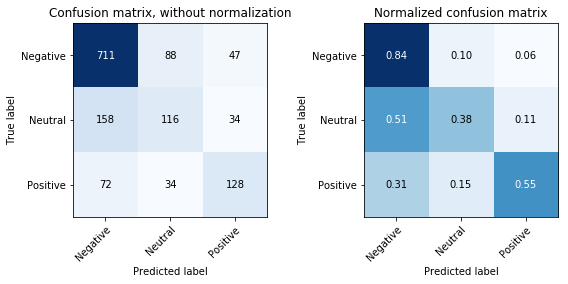

In [ ]:
def model_1c():
    """
    Adding dropout to reduce overfitting using a bidiretional LSTM
    """
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)))
    model.add(Conv1D(64, 4))
#     model.add(Flatten())
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     print(model.summary())
    return model


_ = train(model_1c, 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           checkpoint_path='model_1c.h5',
           class_weights=cws,
           print_summary = True
          )


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 25, 128)           2751744   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 25, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 21, 64)            41024     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 19, 64)            12352     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 18, 64)            8256      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
__________

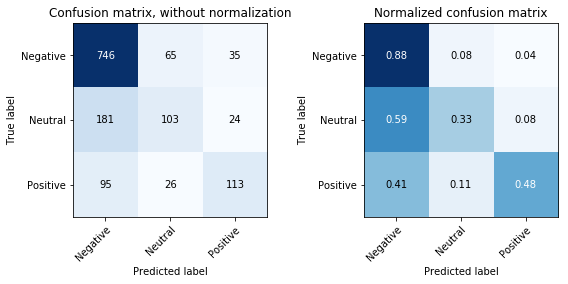

In [ ]:
def model_1d():
    """
    Just for fun below is a model only using covolutions. This is pretty good and also trains very quickly(and predictions would also likely be fast) compared to the LSTM...
    It's equivalent to using an n-gram based approach.
    Usually in practice you would use a more complex architecture with multiple parallel convolutions that are combined before pooling(and usually both max and avg).
    Pure Convolutional NLP is definitely a solution worth exploring further.
    """
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(SpatialDropout1D(0.3))
    model.add(Conv1D(64, 5))
    model.add(Conv1D(64, 3))
    model.add(Conv1D(64, 2))
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


_ = train(model_1d, 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           checkpoint_path='model_1d.h5',
           class_weights=cws,
           print_summary = True
          )

# Using Transfer Learning
---
### Already we have a pretty decent model that makes a sizable improvement upon our initial baselines, but we can do better. Currently we're training our word vectors from scratch and with such a small sample size it's unlikely that the model has sufficiently learned to distinguish the meaning or intent of all 21K tokens. 

### Fortunately, you can access pre-trained word vectors, trained against billions of documents. These are generally recommended for NLP tasks as they provide a substantial increase in performance over embeddings trained on the fly.

### This is a form of Transfer Leanring where existing model weights are re-purposed for a new task (this much more prevalent amongst Image Classification tasks).

### We'll use the GloVe Embeddings, which ar trained on several sources including Twitter(which is particularly relavent).

In [ ]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

def get_embdedings_matrix(embeddings_index, word_index, nb_words = None):
    all_embs = np.stack(embeddings_index.values())
    print('Shape of Full Embeddding Matrix', all_embs.shape)
    embed_dims = all_embs.shape[1]
    emb_mean,emb_std = all_embs.mean(), all_embs.std()

    #best to free up memory, given the size, which is usually ~3-4GB in memory
    del all_embs
    if nb_words is None:
        nb_words = len(word_index)
    else:
        nb_words = min(nb_words, len(word_index))
    
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_dims))
    found_vectors = 0
    words_not_found = []
    for word, i in tqdm(word_index.items()):
        if i >= nb_words: 
            continue
        embedding_vector = None
        if word in embeddings_index:
            embedding_vector = embeddings_index.get(word)
        elif word.lower() in embeddings_index:
            embedding_vector = embeddings_index.get(word.lower())
        # for twitter check if the key is a hashtag
        elif '#'+word.lower() in embeddings_index:
            embedding_vector = embeddings_index.get('#'+word.lower())
            
        if embedding_vector is not None: 
            found_vectors += 1
            embedding_matrix[i] = embedding_vector
        else:
            words_not_found.append((word, i))

    print("% of Vectors found in Corpus", found_vectors / nb_words)
    return embedding_matrix, words_not_found

In [ ]:
def load_glove(word_index):
#     print('Loading Glove')
    embed_file_path = '../input/glove840b300dtxt/glove.840B.300d.txt'
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in tqdm(open(embed_file_path)))
    print("Built Embedding Index:", len(embeddings_index))
    return get_embdedings_matrix(embeddings_index, word_index)

def load_twitter(word_index):
#     print('Loading Twitter')
    embed_file_path = '../input/glove-twitter-27b-200d-txt/glove.twitter.27B.200d.txt'
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in tqdm(open(embed_file_path)))
    print("Built Embedding Index:", len(embeddings_index))
    return get_embdedings_matrix(embeddings_index, word_index)


In [ ]:
print('Loading Glove Model...')
glove_embed_matrix, words_not_found =  load_glove(tokenizer.word_index)

Loading Glove Model...



Built Embedding Index: 2196017


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


Shape of Full Embeddding Matrix (2196017, 300)



% of Vectors found in Corpus 0.6084569939991626


In [ ]:
print('Loading Twitter Model...')
twitter_embed_matrix, words_not_found =  load_twitter(tokenizer.word_index)

Loading Twitter Model...



Built Embedding Index: 1193514


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


Shape of Full Embeddding Matrix (1193514, 200)



% of Vectors found in Corpus 0.5912918081592781


## Model 2: Takes the original Model model_1, and uses a pre-trained GloVe embedding. This should improve the loss slightly and depending on the case a small improvement in accuracy.

Train on 12483 samples, validate on 1388 samples
Epoch 1/25
 - 7s - loss: 0.8475 - acc: 0.6287 - val_loss: 0.8498 - val_acc: 0.6376

Epoch 00001: val_acc improved from -inf to 0.63761, saving model to model_2.h5
Epoch 2/25
 - 5s - loss: 0.7266 - acc: 0.6909 - val_loss: 0.7889 - val_acc: 0.6369

Epoch 00002: val_acc did not improve from 0.63761
Epoch 3/25
 - 5s - loss: 0.6681 - acc: 0.7190 - val_loss: 0.7528 - val_acc: 0.6816

Epoch 00003: val_acc improved from 0.63761 to 0.68156, saving model to model_2.h5
Epoch 4/25
 - 5s - loss: 0.6212 - acc: 0.7425 - val_loss: 0.7313 - val_acc: 0.6837

Epoch 00004: val_acc improved from 0.68156 to 0.68372, saving model to model_2.h5
Epoch 5/25
 - 5s - loss: 0.5696 - acc: 0.7651 - val_loss: 0.7673 - val_acc: 0.6924

Epoch 00005: val_acc improved from 0.68372 to 0.69236, saving model to model_2.h5
Epoch 6/25
 - 5s - loss: 0.5139 - acc: 0.7924 - val_loss: 0.7824 - val_acc: 0.6830

Epoch 00006: val_acc did not improve from 0.69236


********************

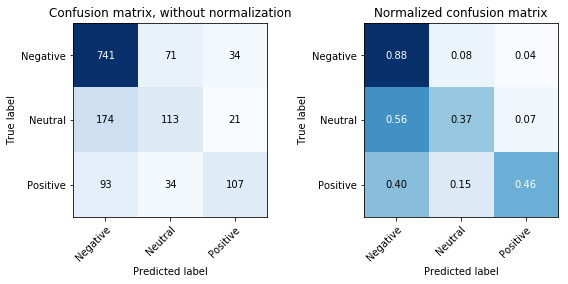

In [ ]:
def model_2(embed_matrix):
    """
    Extends model_1 with a glove embedding
    """
    model = Sequential()
    model.add(Embedding(input_dim = embed_matrix.shape[0], output_dim = embed_matrix.shape[1], input_length = MAX_SEQ_LEN,  weights=[embed_matrix], trainable=False))
    model.add(LSTM(128))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


m2 = train(lambda : model_2(glove_embed_matrix), 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           checkpoint_path='model_2.h5',
           class_weights=cws,
           fit_verbose = 2,
           print_summary = False
          )

# But the question remains what will work better, the Standard GloVe Embedding the Twitter Embedding or Both?
## In order to test that out we'll run an experiment taking the architecture from model_1c and running it with each variation of the embedding. This experiment should provide us with good data to make a choice on which embedding to use going forward.

In [ ]:
def model_3(embed_matrix):
    """
    Extends model 1c, will be trained with multiple embeddings
    """
    model = Sequential()
    model.add(Embedding(input_dim = embed_matrix.shape[0], output_dim = embed_matrix.shape[1], input_length = MAX_SEQ_LEN,  weights=[embed_matrix], trainable=False))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)))
    model.add(Conv1D(64, 4))
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## model_3 with glove, twitter and stacked embeddings


Model 3 w/ Glove Embedding

Epoch 00001: val_acc improved from -inf to 0.66282, saving model to model.hdf5

Epoch 00002: val_acc improved from 0.66282 to 0.67075, saving model to model.hdf5

Epoch 00003: val_acc improved from 0.67075 to 0.67939, saving model to model.hdf5

Epoch 00004: val_acc improved from 0.67939 to 0.68372, saving model to model.hdf5

Epoch 00005: val_acc did not improve from 0.68372

Epoch 00006: val_acc did not improve from 0.68372


****************************


Loading Best Model...
1388/1388 [==============================] - 3s 2ms/step
Validation Loss: 0.7248423317581837
Test Accuracy 0.6837175792507204
F1 Score: 0.6588905343941033
              precision    recall  f1-score   support

    Negative       0.72      0.89      0.80       846
     Neutral       0.53      0.35      0.43       308
    Positive       0.62      0.38      0.47       234

   micro avg       0.68      0.68      0.68      1388
   macro avg       0.63      0.54      0.56      1388
weight

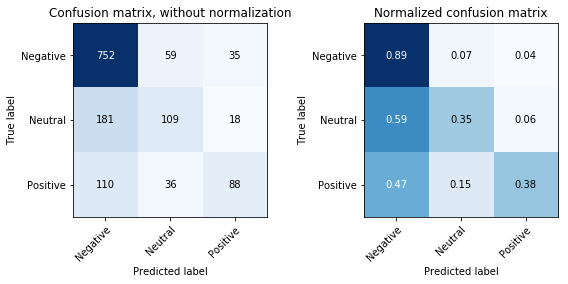


++++++++++++++++++++++++++++++++++++++++++

Model 3 w/ Twitter Embedding

Epoch 00001: val_acc improved from -inf to 0.65274, saving model to model.hdf5

Epoch 00002: val_acc did not improve from 0.65274

Epoch 00003: val_acc improved from 0.65274 to 0.66427, saving model to model.hdf5

Epoch 00004: val_acc improved from 0.66427 to 0.68300, saving model to model.hdf5

Epoch 00005: val_acc improved from 0.68300 to 0.68804, saving model to model.hdf5

Epoch 00006: val_acc improved from 0.68804 to 0.69020, saving model to model.hdf5

Epoch 00007: val_acc improved from 0.69020 to 0.69741, saving model to model.hdf5

Epoch 00008: val_acc improved from 0.69741 to 0.70965, saving model to model.hdf5

Epoch 00009: val_acc did not improve from 0.70965

Epoch 00010: val_acc did not improve from 0.70965


****************************


Loading Best Model...
1388/1388 [==============================] - 3s 2ms/step
Validation Loss: 0.702858628921871
Test Accuracy 0.7096541786743515
F1 Score: 0.690

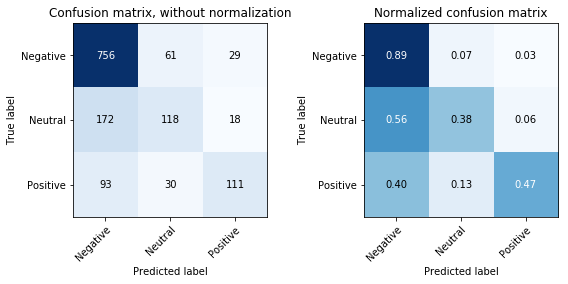


++++++++++++++++++++++++++++++++++++++++++

Model 3 w/ Stacked Embedding

Epoch 00001: val_acc improved from -inf to 0.65706, saving model to model.hdf5

Epoch 00002: val_acc improved from 0.65706 to 0.69308, saving model to model.hdf5

Epoch 00003: val_acc did not improve from 0.69308

Epoch 00004: val_acc improved from 0.69308 to 0.71470, saving model to model.hdf5

Epoch 00005: val_acc did not improve from 0.71470

Epoch 00006: val_acc did not improve from 0.71470


****************************


Loading Best Model...
1388/1388 [==============================] - 3s 2ms/step
Validation Loss: 0.7045267231818436
Test Accuracy 0.7146974063400576
F1 Score: 0.7058688557452977
              precision    recall  f1-score   support

    Negative       0.77      0.85      0.81       846
     Neutral       0.59      0.46      0.52       308
    Positive       0.61      0.55      0.58       234

   micro avg       0.71      0.71      0.71      1388
   macro avg       0.66      0.62      0.63  

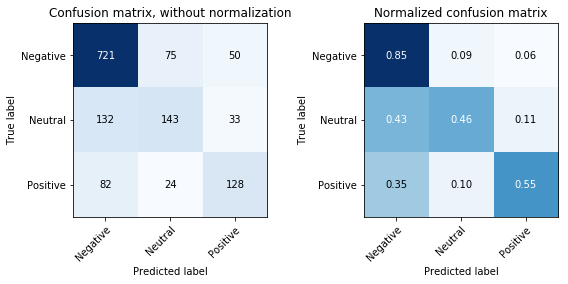

In [ ]:
print("Model 3 w/ Glove Embedding")
_ = train(lambda : model_3(glove_embed_matrix), 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           class_weights=cws,
           fit_verbose=0,
           print_summary = False

          )

print("\n++++++++++++++++++++++++++++++++++++++++++\n")

print("Model 3 w/ Twitter Embedding")
_ = train(lambda : model_3(twitter_embed_matrix), 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           class_weights=cws,
           fit_verbose=0,
           print_summary = False

          )

print("\n++++++++++++++++++++++++++++++++++++++++++\n")

print("Model 3 w/ Stacked Embedding")
_ = train(lambda : model_3(np.hstack((twitter_embed_matrix, glove_embed_matrix))), 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           class_weights=cws,
           fit_verbose=0,
           print_summary = False

          )



## By blending the embeddings we should have a model that's a signicant improvement over the baselines (~5-7% increase in F1 Score).
## Can we improve on the architecture further to increase our performance? Let's test a few hypotheses:

## Hypothesis 1: What if we extend the depth of the convolution (common in image classification)?
## Result: Negligible

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 25, 500)           10748500  
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 25, 500)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 25, 256)           644096    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 22, 64)            65600     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 19, 32)            8224      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 16, 16)            2064      
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 16)                0         
__________

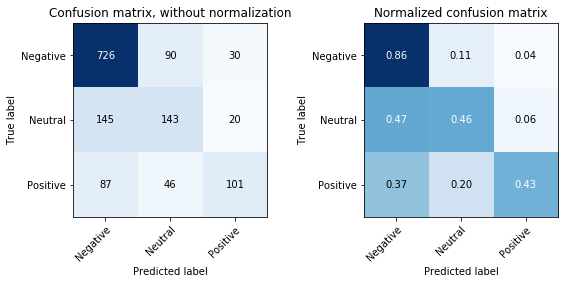

In [ ]:
def model_4(embed_matrix):

    model = Sequential()
    model.add(Embedding(input_dim = embed_matrix.shape[0], output_dim = embed_matrix.shape[1], input_length = MAX_SEQ_LEN,  weights=[embed_matrix], trainable=False))
    model.add(SpatialDropout1D(0.25))
    model.add(Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)))
    model.add(Conv1D(64, 4))
    model.add(Conv1D(32, 4))
    model.add(Conv1D(16, 4))
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


_ = train(lambda : model_4(np.hstack((twitter_embed_matrix, glove_embed_matrix))), 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           class_weights=cws,
           fit_verbose=2,
           print_summary = True
          )



## Hypothesis 2: What if we make the Embedding layer trainable, so that it's weights are updated, by the training data? This should help with addressing Out of Vocabulary Tokens.

## Results: Provides another small boost in accuracy. Retraining the vectors is not alway recommended as you might "lose" useful information from the pre-trained embeddings, but in this context it proves helpful.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 25, 500)           10748500  
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 25, 500)           0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 25, 256)           644096    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 22, 64)            65600     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 195       
Total para

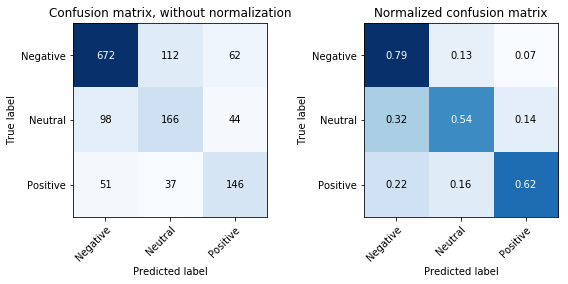

In [ ]:
def model_5(embed_matrix):
    """
    Extends Model 3, but makes the embedding trainable
    """
    model = Sequential()
    model.add(Embedding(input_dim = embed_matrix.shape[0], output_dim = embed_matrix.shape[1], input_length = MAX_SEQ_LEN,  weights=[embed_matrix], trainable=True))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)))
    model.add(Conv1D(64, 4))
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


m5 = train(lambda : model_5(np.hstack((twitter_embed_matrix, glove_embed_matrix))), 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           class_weights=cws,
           fit_verbose=2,
           print_summary = True
          )

## Hypothesis 3: Let's try stacking the LSTM Layers.
## At this point we should see minimal change from our prior model

Train on 12483 samples, validate on 1388 samples
Epoch 1/25
 - 32s - loss: 0.8557 - acc: 0.6323 - val_loss: 0.7779 - val_acc: 0.6650

Epoch 00001: val_acc improved from -inf to 0.66499, saving model to model.hdf5
Epoch 2/25
 - 23s - loss: 0.7129 - acc: 0.6973 - val_loss: 0.7090 - val_acc: 0.6996

Epoch 00002: val_acc improved from 0.66499 to 0.69957, saving model to model.hdf5
Epoch 3/25
 - 23s - loss: 0.6302 - acc: 0.7406 - val_loss: 0.7043 - val_acc: 0.7111

Epoch 00003: val_acc improved from 0.69957 to 0.71110, saving model to model.hdf5
Epoch 4/25
 - 23s - loss: 0.5445 - acc: 0.7795 - val_loss: 0.7779 - val_acc: 0.7097

Epoch 00004: val_acc did not improve from 0.71110
Epoch 5/25
 - 23s - loss: 0.4751 - acc: 0.8115 - val_loss: 0.8229 - val_acc: 0.7003

Epoch 00005: val_acc did not improve from 0.71110


****************************


Loading Best Model...
1388/1388 [==============================] - 6s 5ms/step
Validation Loss: 0.704347924051554
Test Accuracy 0.7110951008645533
F1 

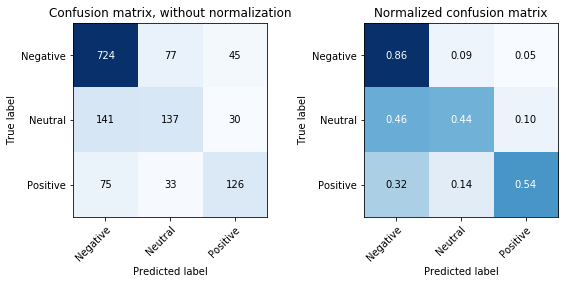

In [ ]:
def model_6(embed_matrix):
    """
    Extends Model 5 and adds another Bidirectional LSTM layer
    """
    model = Sequential()
    model.add(Embedding(input_dim = embed_matrix.shape[0], output_dim = embed_matrix.shape[1], input_length = MAX_SEQ_LEN,  weights=[embed_matrix], trainable=True))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)))
    model.add(Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)))
    model.add(Conv1D(64, 4))
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


m6 = train(lambda : model_6(np.hstack((twitter_embed_matrix, glove_embed_matrix))), 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           class_weights=cws,
           fit_verbose=2,
           print_summary = False
          )



In [ ]:
preds = m6.predict(test_text_vec)
print('Prediction, based on highest class:', (preds.argmax(axis = 1) == y_test.argmax(axis = 1)).mean())
#print('Prediction, based on class > 0.5:', ((y_test * preds).max(axis = 1) > 0.5).mean())

# Also consider searching the threshold, though this requires re-thinking the results, since you're now outputting up to 2 options for a class
# But should help with calling out ambiguous cases
threshold = threshold_search(y_test, preds, average='weighted')
print('Threshold Search:', threshold)
# print('Prediction, after Threshold Search:', (preds.argmax > threshold == y_test.argmax(axis = 1)).mean())

Prediction, based on highest class: 0.7110951008645533
Threshold Search: {'threshold': 0.35000000000000003, 'f1': 0.7134657235923297}


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### So why is the model plateua-ing?
1. We havent done much hyper-parameter tuning, which might help further improve the model's accuracy (e.g. changing batch size, kernel size, LSTM capacity)?
2. We have a small dataset and there's limited information we can extract from it.
3. Human sentiment is a messy thing to measure, See below to look at some of the misclassifications. Would you have correclty classified them?

In [ ]:
from sklearn.metrics import confusion_matrix
print('Residuals Analysis:', )
print(confusion_matrix(y_test.argmax(axis = 1),preds.argmax(axis = 1)))


ctr = 0
for i in range(y_test.shape[0]):
    true_label = y_test[i].argmax()
    pred_label = preds[i].argmax()
    if true_label != pred_label:
        print('idx:', i)
        print('True Label:', encoder.classes_[true_label])
        print('Predicted Label:', encoder.classes_[pred_label])
        print('Probability Prediction', preds[i])
        print(test['sentiment'].values[i], '::',  test['text'].values[i], '\n')
        ctr += 1
    
    if ctr > 20:
        break
        


Residuals Analysis:
[[724  77  45]
 [141 137  30]
 [ 75  33 126]]
idx: 0
True Label: Positive
Predicted Label: Negative
Probability Prediction [0.5881 0.4471 0.358 ]
Positive :: To me, the real winner of last night #GOPDebate was @megynkelly. #MegynKelly 

idx: 12
True Label: Positive
Predicted Label: Neutral
Probability Prediction [0.116  0.8772 0.0368]
Positive :: Wondering how the day after the #GOPDebate is going? I've ordered Dominos and read through my watch party swag: http://t.co/NQqXm33AEr 

idx: 13
True Label: Neutral
Predicted Label: Negative
Probability Prediction [0.6952 0.5837 0.0161]
Neutral :: RT @kristenjobarton: me @ #GOPDebate talking about Planned Parenthood http://t.co/OYIZmqZoWj 

idx: 18
True Label: Neutral
Predicted Label: Negative
Probability Prediction [0.5891 0.5698 0.0462]
Neutral :: RT @JimSterling: Phew! Tuned into the #GOPDebate just in time! http://t.co/BIVfRZKaF4 

idx: 21
True Label: Neutral
Predicted Label: Positive
Probability Prediction [0.295  0.17

### Also, there are plenty of words that arent found in the corpus, that might help improve the interpretation of the text...

In [ ]:
words_not_found[:20]

[('GOPDebate', 1),
 ('GOPDebates', 5),
 ('RWSurferGirl', 15),
 ('🇺🇸', 17),
 ('realDonaldTrump', 29),
 ('megynkelly', 60),
 ('GOPdebate', 80),
 ('GOPdebates', 97),
 ("night's", 136),
 ('gopdebate', 156),
 ('2', 158),
 ('CarlyFiorina', 159),
 ('monaeltahawy', 160),
 ('GopDebates', 165),
 ('G…', 170),
 ('SupermanHotMale', 177),
 ('TedCruz', 193),
 ('GOPDebat…', 200),
 ('1', 244),
 ('HillaryClinton', 245)]

# Where to go from here? Next Steps
----

### The final model approaches an Accuracy/F1 of 70 - 71%(almost 10% improvement in F1 from our baseline) and it seems like there might be a bit of plateau caused in-part by the amiguity of the data. So now that learning has plateau'd there are still some areas to explore to further improve on our model.
1. Hyperparameter Tuning - Batch Size, DropOut Rate, LSTM Size, etc.
2. Try to generate/collect new data to help with performance (translation augmentation is one technique). 
3. Perform Threshold Search to see if that can improve the accuracy of the model, by changing the decision threshold for classifcation (default is 0.5). Usually good for a small "free" boost.
4. Consider adding meta-data(likes, retweets, num followers) or additional statistical feature e.g. Count of Punctuation, Count all CAPS words, etc.
5. Use cross validation to analyze architecture. In this example I mostly just did one pass on a give model, to see what choices would make the greatest impact, but when fine-tuning a model it's often helpful to use 10-Fold Cross Validation to confirm if the architectural change produces a statistically significant imrpovement, especiially when considering using the models in a commercial setting where cost would be a factor.
6. Start Exploring more complex architectures to get an additional edge, sinc deep learning is an evolving field it's always good to keep reading and learning new techniques, which seem to get better every 2-3 months.

# [Winning architecture for Quora Challenge](https://www.kaggle.com/c/quora-insincere-questions-classification/discussion/80568)
![Imaget](https://i.imgur.com/zUY9tVN.png)

# [KD Nuggets Benchmarking RNNs to Machine Learning Based Approaches](https://www.kdnuggets.com/2018/07/overview-benchmark-deep-learning-models-text-classification.html)

![Image From KD Nuggets](https://ahmedbesbes.com/images/article_5/rnn_cnn_model.png)